# Logistic Regression with Newton's Method via Jax (Assignment)

**Logistic Regression** is a **binary classification algorithm** used to separate data into different categories. For example, logistic regression can be used to determine if an email is spam or not spam. 

Unlike **linear regression**, which predicts continuous values, logistic regression predicts **probabilities** that map to two possible categories (0 or 1). This is difference between regression and classification. This is achieved using the **sigmoid function**, which converts any real-valued input into a probability between **0 and 1**.

The functional form of the sigmoid function is 
\begin{equation} 
\sigma(z) = \frac{1}{1 + e^{-z}}.
\end{equation} 

The sigmoid function has an output between 0 and 1, which we interpret as a probability. 

Denote the predictor variables as $x_n$ and the predicted probability as $\hat{y}$. Logistic regression is a two-step process, a linear transformation followed by a non-linear transformation. 

* Step 1, linear transformation
\begin{equation}
    z = \beta_0 +  \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n, 
\end{equation}
where $ \beta_1,~ \beta_2,~ ...,~ \beta_n $ are the model weights and $ \beta_0 $ is the bias term. 

* Step 2, convert to probability via the sigmoid function
\begin{equation}
    \hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}.
\end{equation}

Below is a plot of the sigmoid function. 

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import display, Image
from IPython.display import HTML

from jax import grad, hessian, jit
import jax.numpy as jnp
from functools import partial 

from sklearn.linear_model import LogisticRegression as logreg

import sympy as sym 

In [2]:
def sigmoid(z):
    """Compute the sigmoid function."""
    return 1 / (1 + jnp.exp(-z))

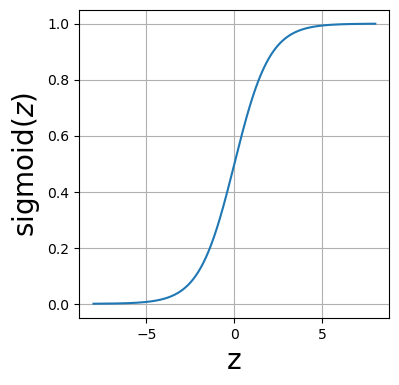

In [3]:
z=np.linspace(-8,8,1000)

fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot()
ax.set_xlabel(r"z", size=20) 
ax.set_ylabel(r"sigmoid($z$)", size=20) 
ax.plot(z, sigmoid(z))
ax.grid()


 To classify an input, we apply a the following threshold:
- If $ \sigma(z) \geq 0.5 $, classify as **1** (positive class)  
- If $ \sigma(z) < 0.5 $, classify as **0** (negative class).

For example, consider the spam or not spam case, an output of $\sigma(z)=.6$ is classified as spam while an output of $\sigma(z)=.32$ is classified as not spam. 

The figure below separates the sigmoid plot into regions of positive and negative classification. 

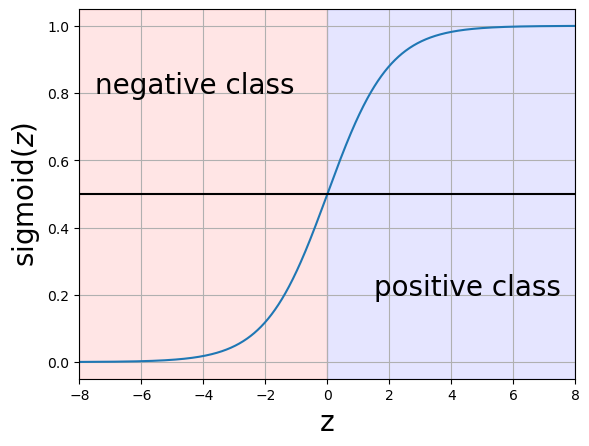

In [4]:
z=jnp.linspace(-8,8,1000)

fig=plt.figure()
ax=fig.add_subplot()
ax.set_xlabel(r"z", size=20) 
ax.set_ylabel(r"sigmoid($z$)", size=20) 
ax.set_xlim(z[0], z[-1])
ax.plot(z, sigmoid(z))
ax.axhline(.5, color="black")

# fills
ax.axvspan(0, np.max(z), color='blue', alpha=0.1)
ax.axvspan(z[0], 0, color='red', alpha=0.1)

ax.annotate('positive class', xy=(1.5, .2), fontsize=20)
ax.annotate('negative class', xy=(-7.5, .8), fontsize=20)
            
ax.grid()

## Cost Function Log Loss (Binary Cross-Entropy)  
Logistic regression uses the **log loss** (binary cross-entropy), 
\begin{equation}
 \text{log loss}=- \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]. 
\end{equation} 
where:  
- $ \hat{y}^{(i)}$ is the predicted probability  
- $y^{(i)} $ is the actual class label (0 or 1)  
- $ m $ is the number of training samples

The log loss function penalizes the model based on how far its predicted probabilities are from the actual outcomes. If the model predicts a high probability for the correct class, the log loss is low (good). If the model predicts a low probability for the correct class, the log loss is high (bad).

You might say that the log loss is very unhappy when a model is confident and wrong. It's happier when the model is less confident, even if it's still wrong.

This encourages the model to make more calibrated predictions, where its confidence matches the actual likelihood of an outcome. Here are some examples: 

Imagine you are trying to predict whether it will rain tomorrow:
- You predict a **90% chance of rain**, $p=0.9$.
- If it **does** rain, your prediction was good.
- If it **doesn't** rain, your confident prediction was very wrong and should be heavily penalized.

The more confident you are in the **wrong** direction, the greater the penalty. Log loss captures this behavior.

Suppose you predict a 90% chance of rain and it does rain (y=1). The log loss evaluates: 
\begin{equation}
\begin{split} 
\text{log loss} & = -\left[ y \log(p) + (1 - y) \log(1 - p) \right] \\
& = -\left[ 1 \cdot \log(0.9) + 0 \cdot \log(0.1) \right] \\
&= -\log(0.9) \approx 0.1054.
\end{split} 
\end{equation} 

Suppose you predict a 90% chance of rain and it does not rain (y=0). The log loss evaluates: 
\begin{equation}
\begin{split} 
\text{log loss} & = -\left[ y \log(p) + (1 - y) \log(1 - p) \right] \\
&= -\left[ 0 \cdot \log(0.9) + 1 \cdot \log(1 - 0.9) \right] \\
&= -\log(0.1) \approx 2.3026. 
\end{split} 
\end{equation} 

We should understand what the log looks like, below is a plot of $\log(x)$.

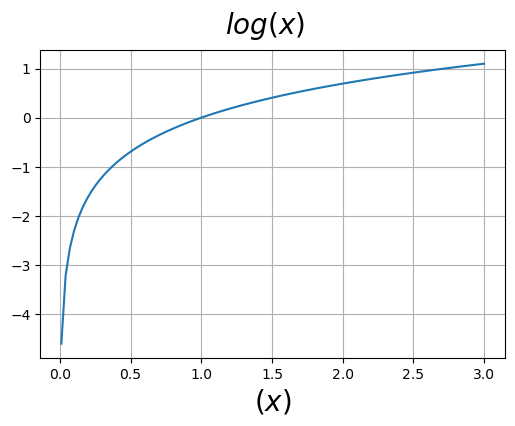

In [5]:
x = np.linspace(.01, 3, 100) 
fig=plt.figure(figsize=(6,4))
fig.suptitle(r"$log(x)$", size=20) 
ax=fig.add_subplot()
ax.set_xlabel(r"$(x)$", size=20) 
ax.plot(x, np.log(x))
ax.grid()

## Simulating Data for a Numerical Experiment 
We will conduct a numerical experiment, in which we simulate data, perform logistic regression on the simulated data, and compare the fitted parameters to the true parameters. We will also compare our fits to Sklearn. 

Our model will mimic simple logistic regression, in which we have one feature $x$. The transformation of the data to a probability is 
\begin{equation} 
\begin{split} 
& z = \beta_0 + \beta_1 x\\
& \hat{y} = \sigma(z) 
\end{split} 
\end{equation} 

* Choose model parameters, $\beta_0$ and $\beta_1$. We will call these true_beta_0 and true_beta_1.
* Sample 100 $x$ values from a uniform distribution from -10 to 10. 
* Transform the data to a probability. 

With the probability in hand, sample from a binomial distribution. This will create an array of 1s and 0s.

The NumPy function [random.binomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html) samples from a binomial distribution. Here is the NumPy documentation: 

*Samples are drawn from a binomial distribution with specified parameters, n trials, and p probability of success where n is an integer >= 0 and p is in the interval [0,1]. (n may be input as a float, but it is truncated to an integer in use)*

For our simulation, we will have $n=1$, i.e., one trial, and $p$ the output of our model. 

Flipping a coin is a good way to understand the random.binomial functionality. We can label outputs of 1 as heads and outputs of 0 as tails. 

Here are a few cases that you should code to see how random.binomial operates. Since we are sampling probability distributions, you should execute each example a few times, so that you observe the probabilistic nature of the sampling (the outcomes will change with each execution). 

* Flip one coin. The coin is fair with an equal chance for heads or tails, i.e., p=0.5.
```python

In [6]:
# Set coefficients
true_beta_0 = -0.5   # intercept
true_beta_1 = 0.2  # slope

# Generate random x values (feature)
np.random.seed(42)
m=100 # number of samples 

x=jnp.array(np.random.uniform(-10, 10, m)) 


# transform features
z = true_beta_0 + true_beta_1 * x
p = sigmoid(z)

# sample from binomial distribution  
y_true = np.random.binomial(1, p)

In the code below, I make a schematic plot of the log loss function, by making a grid of $\beta_0$ and $\beta_1$ values, using the simulated data. 

In [7]:
# Compute log loss for each pair (beta_0, beta_1)
# used to make the log-loss surface plot 
def compute_log_loss(beta_0, beta_1, eps=1e-15):
    x = np.random.uniform(-5,5, size=100)
    z = beta_0 + beta_1 * x[:, np.newaxis, np.newaxis]
    p = sigmoid(z)
    p = np.clip(p, eps, 1 - eps)
    
    loss = - (y_true[:, np.newaxis, np.newaxis] * np.log(p) +
              (1 - y_true[:, np.newaxis, np.newaxis]) * np.log(1 - p))
    return np.mean(loss, axis=0)

In [8]:
beta_0=np.linspace(-1,1,20)
beta_1=np.linspace(-1,1,20) 

B0, B1=np.meshgrid(beta_0, beta_1) 

cost = compute_log_loss(B0, B1)

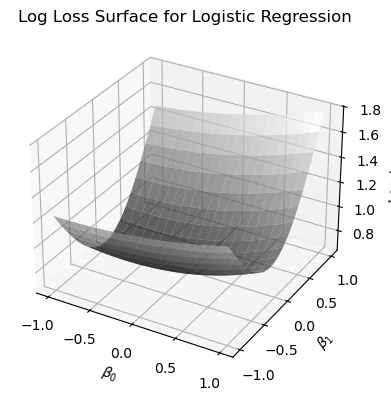

In [9]:
# Plotting
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B0, B1, cost, cmap='gray', edgecolor='none', alpha=0.7)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('Log Loss')
ax.set_title('Log Loss Surface for Logistic Regression')
plt.tight_layout()


## Assignment 

Now that you have simulated data in hand, write a code to fit a logistic regression model to the data. You should use Newton's method as the optimizer, see the Newton's method notebook. You can use Jax to obtain the gradient and Hessian of the loss function. Or, if you prefer, you can code the gradient and Hessian yourself. I provide SymPy code to obtain those expressions below. Additionally, you can find the derivations below, after the SymPy code. 

Here is a skeleton of how I coded the solution. 

1) I wrote a function for the log loss function. The function had three parameters, beta, x, y, eps=1e-15. Here is a snippet of that function:
```
   def log_loss(y_true, y_pred, eps=1e-15):
    """
    Compute the binary log loss.
    
    Parameters:
        y_true (array-like): True labels (0 or 1).
        y_pred (array-like): Predicted probabilities (between 0 and 1).
        eps (float): Small value to avoid log(0).
        
    Returns:
        float: Mean log loss.
    """
```
2) I Chose initial values for the beta vector. Note the elements of the beta vector are $\beta_0$ and $\beta_1$. (Don't choose the solution, i.e., true_beta_0 and true_beta_1.) 
3) I used Jax for the gradient and Hessian, argnums, so Jax takes derivatives of the first parameter only. 
4) I used a loop to iterate through Newton's Method steps.

Here is the Sklearn solution. The results I got using my from scratch Newton optimizer match the Sklearn solution to at least 4 decimal places.

In [10]:
model=logreg(penalty=None)
model.fit(x.reshape(-1, 1),y_true)
print(model.coef_, model.intercept_) 

[[0.18956138]] [-0.51176254]


Using Sympy for the derivatives. 

In [11]:
beta_0, beta_1 = sym.symbols("beta_0, beta_1") 
x, y=sym.symbols(r"x y")

z = beta_0 + beta_1*x
yhat = 1/(1 + sym.exp(-z))



In [12]:
loss = -y*sym.log(yhat) - (1-y)*sym.log(1-yhat)
loss

-y*log(1/(exp(-beta_0 - beta_1*x) + 1)) - (1 - y)*log(1 - 1/(exp(-beta_0 - beta_1*x) + 1))

In [13]:
grad_1 = loss.diff(beta_0)
sym.simplify(grad_1)

(-y*exp(beta_0 + beta_1*x) - y + exp(beta_0 + beta_1*x))/(exp(beta_0 + beta_1*x) + 1)

In [14]:
grad_2 = loss.diff(beta_1)
sym.simplify(grad_2)

x*(-y*exp(beta_0 + beta_1*x) - y + exp(beta_0 + beta_1*x))/(exp(beta_0 + beta_1*x) + 1)

In [15]:
hess_11 = loss.diff(beta_0, 2)
sym.simplify(hess_11)

exp(beta_0 + beta_1*x)/(2*exp(beta_0 + beta_1*x) + exp(2*beta_0 + 2*beta_1*x) + 1)

In [16]:
hess_22 = loss.diff(beta_1, 2)
sym.simplify(hess_22)

x**2*exp(beta_0 + beta_1*x)/(2*exp(beta_0 + beta_1*x) + exp(2*beta_0 + 2*beta_1*x) + 1)

In [17]:
hess_12 = loss.diff(beta_0).diff(beta_1)
sym.simplify(hess_12)

x*exp(beta_0 + beta_1*x)/(2*exp(beta_0 + beta_1*x) + exp(2*beta_0 + 2*beta_1*x) + 1)

## Gradient and Hessian for Logistic Regression

Similar to linear regression, we organize the predictive variables into a design matrix $X \in \mathbb{R}^{n \times p+1}$, 
\begin{equation}
X = \begin{bmatrix}
1 & x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_p \\
1 & x^{(2)}_1 & x^{(2)}_2 & \cdots & x^{(2)}_p \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x^{(n)}_1 & x^{(n)}_2 & \cdots & x^{(n)}_p
\end{bmatrix},
\end{equation}
where each row $\mathbf{x}^{(i)}$ represents the features for sample $i$, with a leading 1 to account for the intercept $\beta_0$. For logistic regression, we follow a two-step process to predict a probability: a linear transformation followed by a nonlinear transformation. For the parameter vector $\mathbf{\beta} = [\beta_0, \beta_1, \ldots, \beta_p]^T$ and predictive data $X$, the probability prediction is given by
\begin{equation}
\mathbf{\hat{y}} = \sigma(\mathbf{z}) = \frac{1}{1 + e^{-\mathbf{z}}},
\end{equation} 
where $\mathbf{z} = X\mathbf{\beta}$. The sigmoid function $\sigma$ is applied element-wise to produce the vector of predicted probabilities.

For a single training example $(\mathbf{x}^{(i)}, y^{(i)})$, the loss is given by
\begin{equation}
\ell^{(i)} = -\left[y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)})\right]. 
\end{equation}
Using the chain rule, we can write
\begin{equation}
\frac{\partial \ell^{(i)}}{\partial \beta_j} = \frac{\partial \ell^{(i)}}{\partial \hat{y}^{(i)}} \cdot \frac{\partial \hat{y}^{(i)}}{\partial \beta_j}.
\end{equation}
The derivative of the loss with respect to $\hat{y}^{(i)}$ is
\begin{equation}
\frac{\partial \ell^{(i)}}{\partial \hat{y}^{(i)}} = -\frac{y^{(i)}}{\hat{y}^{(i)}} + \frac{1-y^{(i)}}{1-\hat{y}^{(i)}}.
\end{equation}
For the second term, we use the fact that $\hat{y}^{(i)} = \sigma(\mathbf{\beta}^T \mathbf{x}^{(i)})$, which gives
\begin{equation}
\frac{\partial \hat{y}^{(i)}}{\partial \beta_j} = \sigma'(\mathbf{\beta}^T \mathbf{x}^{(i)}) \cdot x_j^{(i)} = \hat{y}^{(i)}(1-\hat{y}^{(i)}) \cdot x_j^{(i)},
\end{equation}
where we have used the convenient property of the sigmoid function that $\sigma'(z) = \sigma(z)(1-\sigma(z))$. Combining these results yields
\begin{equation}
\frac{\partial \ell^{(i)}}{\partial \beta_j} = \left[-\frac{y^{(i)}}{\hat{y}^{(i)}} + \frac{1-y^{(i)}}{1-\hat{y}^{(i)}}\right] \cdot \hat{y}^{(i)}(1-\hat{y}^{(i)}) \cdot x_j^{(i)}.
\end{equation}
Expanding and simplifying the expression in brackets gives
\begin{equation}
\frac{\partial \ell^{(i)}}{\partial \beta_j} = \left[-y^{(i)}(1-\hat{y}^{(i)}) + (1-y^{(i)})\hat{y}^{(i)}\right] \cdot x_j^{(i)} = (\hat{y}^{(i)} - y^{(i)}) \cdot x_j^{(i)}.
\end{equation}
Summing over all $n$ training examples and accounting for the factor of $1/n$ in the log loss definition, the gradient in vector form is
\begin{equation}
\nabla L(\mathbf{\beta}) = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^{(i)} - y^{(i)}) \mathbf{x}^{(i)} = \frac{1}{n} X^T (\mathbf{\hat{y}} - \mathbf{y}),
\end{equation}
where $\mathbf{\hat{y}}, \mathbf{y} \in \mathbb{R}^{n}$ are column vectors of predictions and true labels, respectively.

The Hessian matrix contains the second-order partial derivatives and is defined element-wise as
\begin{equation}
H_{jk} = \frac{\partial^2 L}{\partial \beta_j \partial \beta_k}.
\end{equation}
Starting from the gradient expression
\begin{equation}
\frac{\partial L}{\partial \beta_j} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^{(i)} - y^{(i)}) x_j^{(i)},
\end{equation}
we take the derivative with respect to $\beta_k$ to obtain
\begin{equation}
H_{jk} = \frac{1}{n} \sum_{i=1}^{n} \frac{\partial \hat{y}^{(i)}}{\partial \beta_k} x_j^{(i)}.
\end{equation}
Note that the term $y^{(i)}$ does not depend on $\beta_k$, so its derivative vanishes. Using the result from earlier that $\frac{\partial \hat{y}^{(i)}}{\partial \beta_k} = \hat{y}^{(i)}(1-\hat{y}^{(i)}) x_k^{(i)}$, we have
\begin{equation}
H_{jk} = \frac{1}{n} \sum_{i=1}^{n} \hat{y}^{(i)}(1-\hat{y}^{(i)}) x_j^{(i)} x_k^{(i)}.
\end{equation}
This can be written compactly in matrix form as
\begin{equation}
H = \frac{1}{n} X^T D X,
\end{equation}
where $D \in \mathbb{R}^{n \times n}$ is a diagonal matrix with entries
\begin{equation}
D_{ii} = \hat{y}^{(i)}(1-\hat{y}^{(i)}).
\end{equation}

The Hessian matrix has several important properties. First, the Hessian is positive semi-definite. To see this, consider an arbitrary vector $\mathbf{v} \in \mathbb{R}^{p+1}$ and compute the quadratic form
\begin{equation}
\mathbf{v}^T H \mathbf{v} = \frac{1}{n} \mathbf{v}^T X^T D X \mathbf{v} = \frac{1}{n} (X\mathbf{v})^T D (X\mathbf{v}) = \frac{1}{n} \sum_{i=1}^{n} D_{ii} (X\mathbf{v})_i^2.
\end{equation}
Since $D_{ii} = \hat{y}^{(i)}(1-\hat{y}^{(i)}) \geq 0$ for all $i$ (because $0 \leq \hat{y}^{(i)} \leq 1$), each term in the sum is non-negative, which implies $\mathbf{v}^T H \mathbf{v} \geq 0$ for all $\mathbf{v}$. Thus, $H$ is positive semi-definite.

Second, the positive semi-definiteness of the Hessian guarantees that the log loss is convex. A twice-differentiable function is convex if and only if its Hessian is positive semi-definite everywhere in its domain. Since we have shown that $H \succeq 0$ (where the symbol $\succeq$ denotes positive semi-definiteness) for all values of $\boldsymbol{\beta}$, the log loss function $L(\boldsymbol{\beta})$ is convex. This convexity property is crucial because it guarantees that any local minimum is also a global minimum, and that Newton's method (if it converges) will converge to the optimal solution.

The update rule for Newton's method is given by
\begin{equation}
\boldsymbol{\beta}_{new} = \boldsymbol{\beta}_{old} - H^{-1} \nabla L(\boldsymbol{\beta}_{old}).
\end{equation}
At each iteration, we compute the gradient and Hessian at the current parameter values, solve the linear system $H \boldsymbol{\Delta x} = -\nabla L(\boldsymbol{\beta}_{old})$ for the search direction $\boldsymbol{\Delta x}$, and update $\boldsymbol{\beta}_{new} = \boldsymbol{\beta}_{old} + \boldsymbol{\Delta x}$. Because the log loss is convex and the Hessian is positive definite (assuming the data is not degenerate), Newton's method will converge quadratically to the global optimum when started from a reasonable initial point.